# Check

In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

import umap.umap_ as umap
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import xarray as xr

from scripts_py import loader
%config InlineBackend.figure_format="retina"

Loading model and data
Done !


## Load scatterings

In [2]:
scatterings, _ = pickle.load(open(loader.scattering_coef_path+"Scat_coef_"+loader.pooling+"_"+loader.data_file, "rb"))
sampling_rate = loader.stream[0].stats.sampling_rate

# Offset on loader timer
loader.times -= loader.times[0]

# Extract scattering coefficients
ds = loader.reshape_scatterings(scatterings)

# Get the scattering coefficients (log)
ds = np.log(ds + 1e-20)

# Normalize and select
ds.order_2.data -= ds.order_1.data[:, :, :, None]
ds.order_1.data /= ds.order_1.data.std()
ds.order_1.data -= ds.order_1.data.min()
ds.order_2.data /= ds.order_2.data.std() 
ds.order_2.data -= ds.order_2.data.min()
ds = ds.where(ds.f2 < ds.f1, 0)
ds["order_1"] = ds.order_1.mean(dim="f2")
ds = ds.dropna(dim="time", how="all")

sc = ds.copy() 

# Stacking matrix
n_samples = sc.time.shape[0]
times = sc.time
x1 = sc.order_1.data.reshape(n_samples, -1)
x2 = sc.order_2.data.reshape(n_samples, -1)
dp_scat_spect = np.hstack((x1, x2))

# print info about shape
n_times, n_coeff = dp_scat_spect.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 800 samples of 350 dimensions each.


## Extrernal data

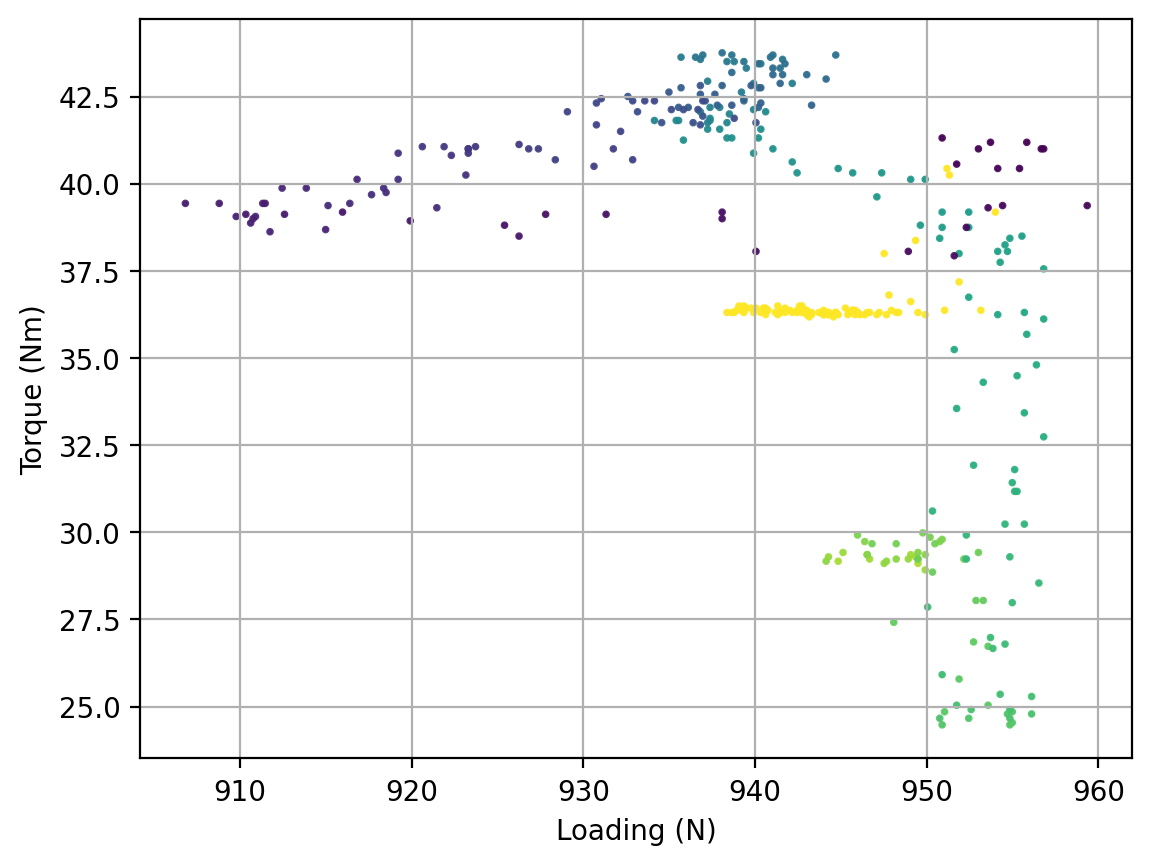

In [ ]:
# Load and resample parametric data
Param = pickle.load(open(loader.param_path+".pkl", "rb"))

# Get data
loading = Param.PARA1
displacement = Param.PARA2
time = Param.time

# Keep only values in percentiles
displacement = displacement.clip(*np.percentile(displacement, [5, 95]))

# Show
fig, ax = plt.subplots()
ax.scatter(loading, displacement + time * 0, c=time, s=1, alpha=0.2)
ax.set_xlabel("Loading (N)")
ax.set_ylabel("Displacement ($\mu$m)")
ax.grid()
plt.show()

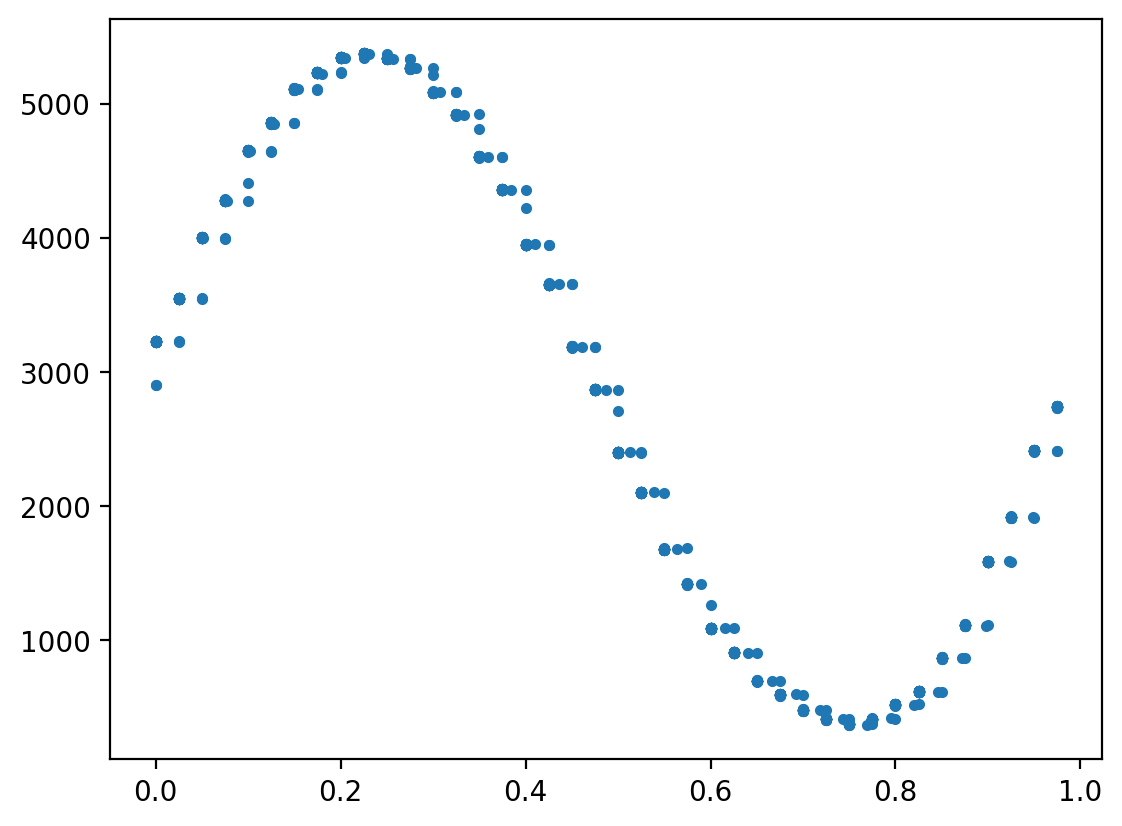

In [6]:
plt.figure()
plt.plot(Param.norm_cy,Param.PARA1,'.')

## Diagramme de phase

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_8127/2925189916.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("ang_pos $u$ ($\mu$m)")
/tmp/ipykernel_8127/2925189916.py:23: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel("ang_pos rate $\dot u$ ($\mu$m/s)")


Text(0, 0.5, 'ang_pos rate $\\dot u$ ($\\mu$m/s)')

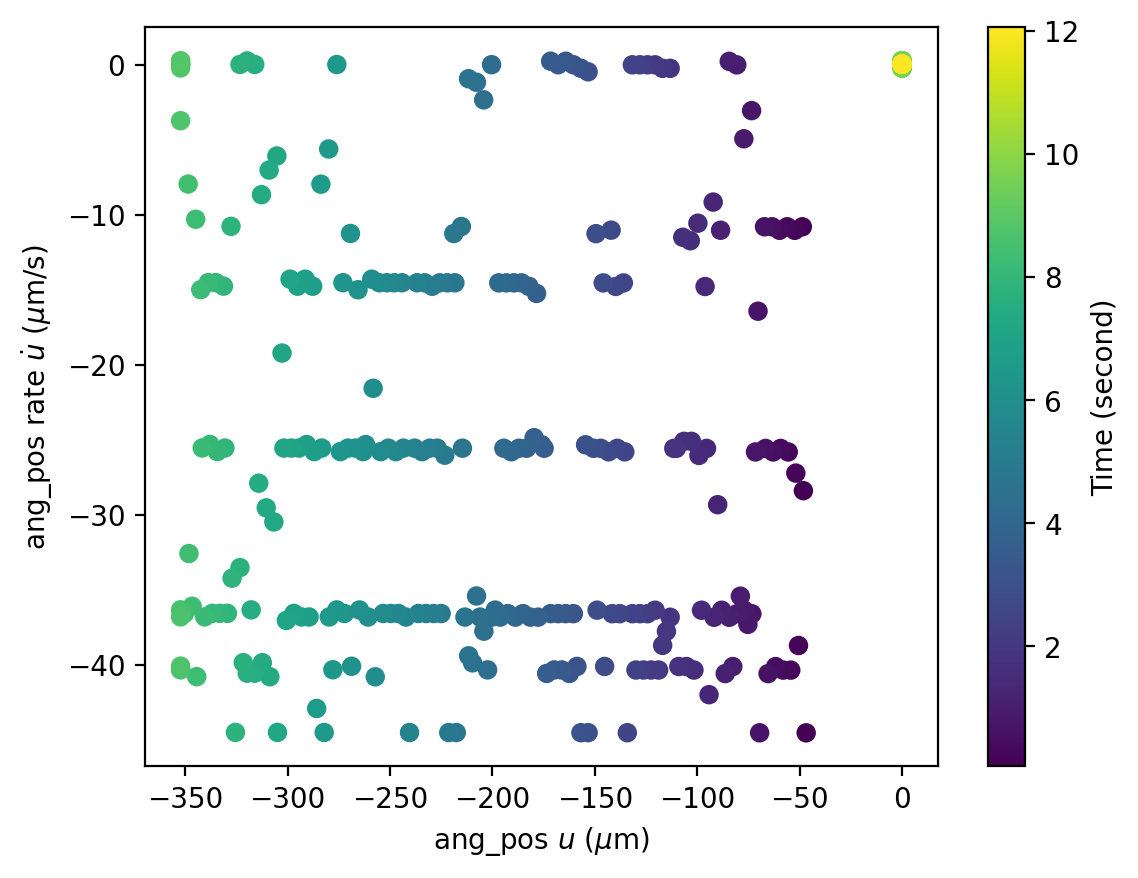

In [16]:
# Get phase diagram
displacement_smooth = Param['PARA2'].rolling(30).mean()
displacement_rate = displacement_smooth.diff()
u, du = displacement_smooth, displacement_rate
to_drop = pd.isna(du)
u = u[~to_drop]
du = du[~to_drop] 
time = Param.time[~to_drop].values
dt = time[1000] - time[999]
du_dt = du / dt

# Clip phase diagram
clipper = [3, 99]
u = u.clip(*np.percentile(u, clipper))
du_dt = du_dt.clip(*np.percentile(du_dt, clipper))

# Show
fig, ax = plt.subplots()
mappable = ax.scatter(u, du_dt + 0.004 * time, c=time)
cb = plt.colorbar(mappable, ax=ax)
cb.set_label("Time (second)")
ax.set_xlabel("Displacement $u$ ($\mu$m)")
ax.set_ylabel("Displacement rate $\dot u$ ($\mu$m/s)")

In [17]:
from obspy import UTCDateTime

with open("data/leonard_outputs/components_"+loader.model_file, "rb") as file:
    features = pickle.load(file)

features = features.assign_coords({"time": [pd.to_datetime(UTCDateTime(t).datetime) for t in features.time.values]})
features = features.sortby("time")

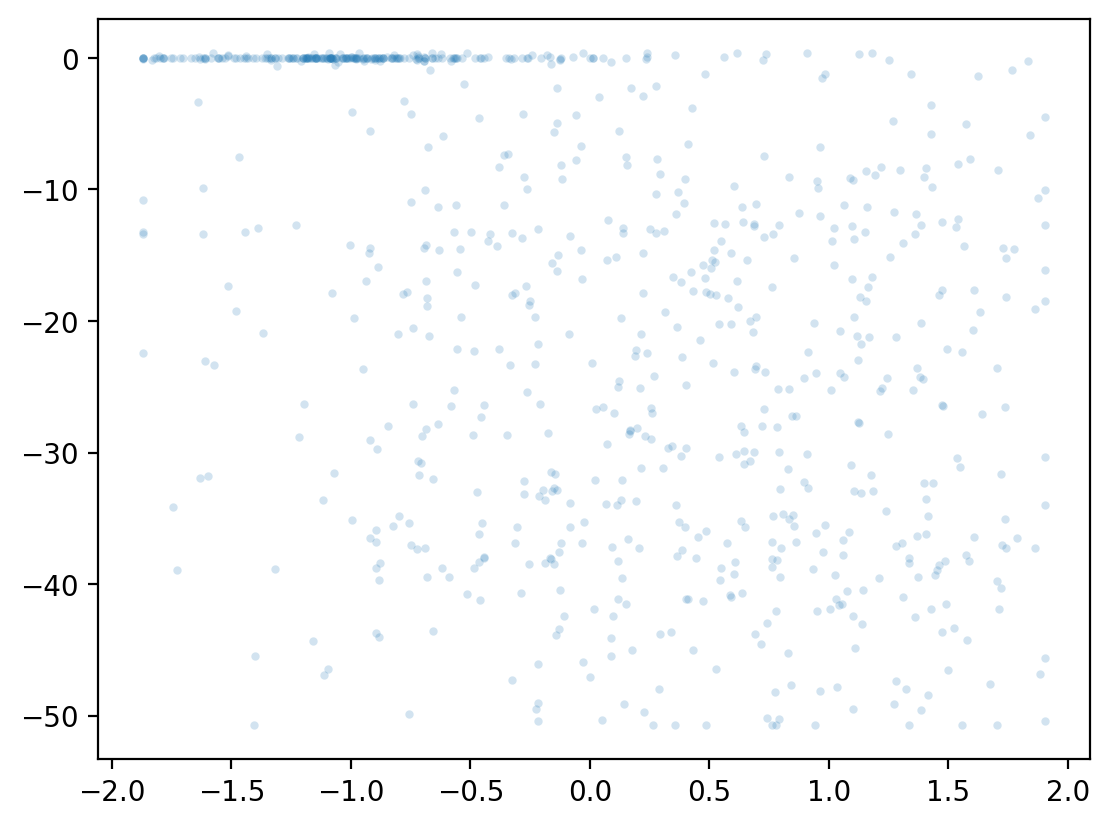

In [18]:
from scipy import signal

x = features.isel(feature=0).values
y = du_dt
y = signal.resample_poly(y, len(x), len(y), padtype='line')

clipper = 1, 99
x = x.clip(*np.percentile(x, clipper))
y = y.clip(*np.percentile(y, clipper))

fig, ax = plt.subplots()
ax.plot(x, y, ".", alpha=0.2, mew=0)

In [19]:
with open("data/leonard_outputs/clusters_"+loader.model_file, "rb") as file:
    clusters = pickle.load(file)


Text(0, 0.5, 'External data')

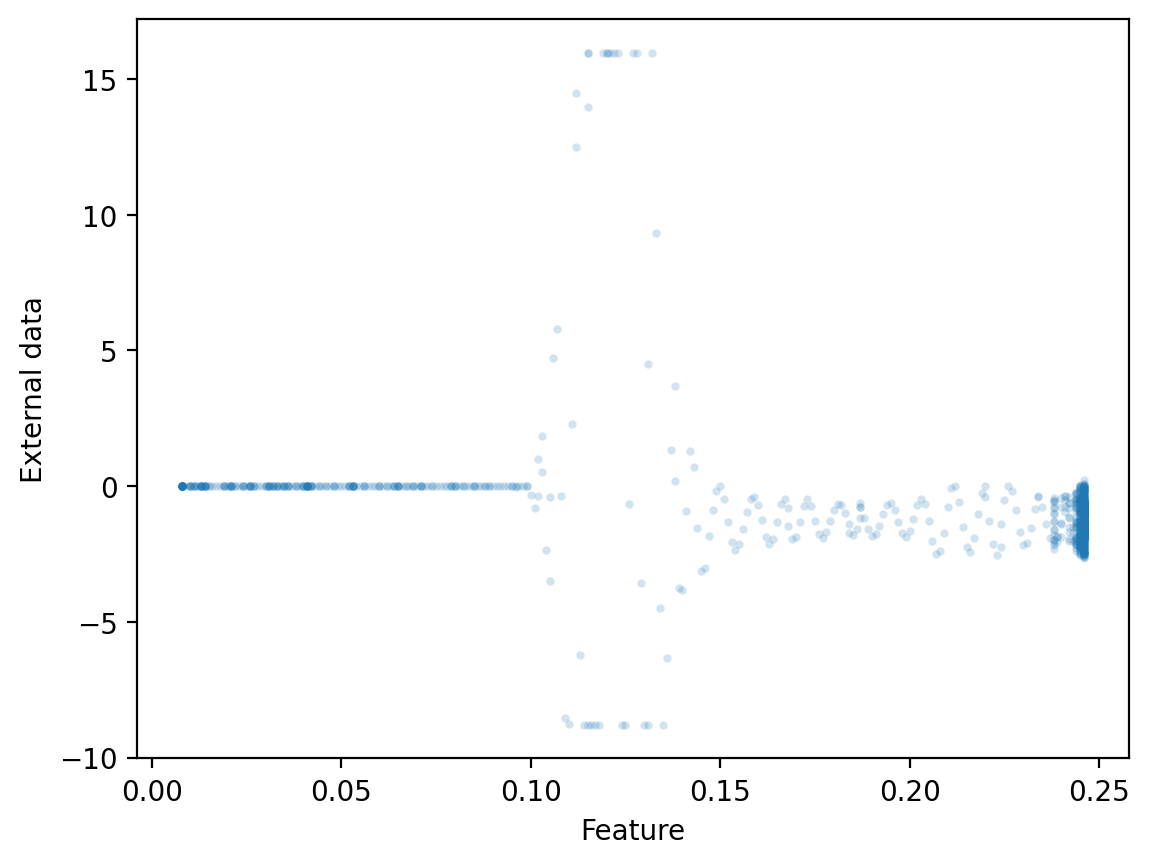

In [20]:
SMOOTH_KERNEL = 1000
x = clusters.isel(cluster=2).values
x = np.convolve(x, np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
y = du
y = signal.resample_poly(y, len(x), len(y), padtype='line')

clipper = 1, 99
x = x.clip(*np.percentile(x, clipper))
y = y.clip(*np.percentile(y, clipper))

fig, ax = plt.subplots()
ax.plot(x, y, ".", alpha=0.2, mew=0)
ax.set_xlabel("Feature")
ax.set_ylabel("External data")

In [21]:
stream_signal = loader.stream[0][:]
stream_time = loader.stream[0].times()

1.0


<StemContainer object of 3 artists>

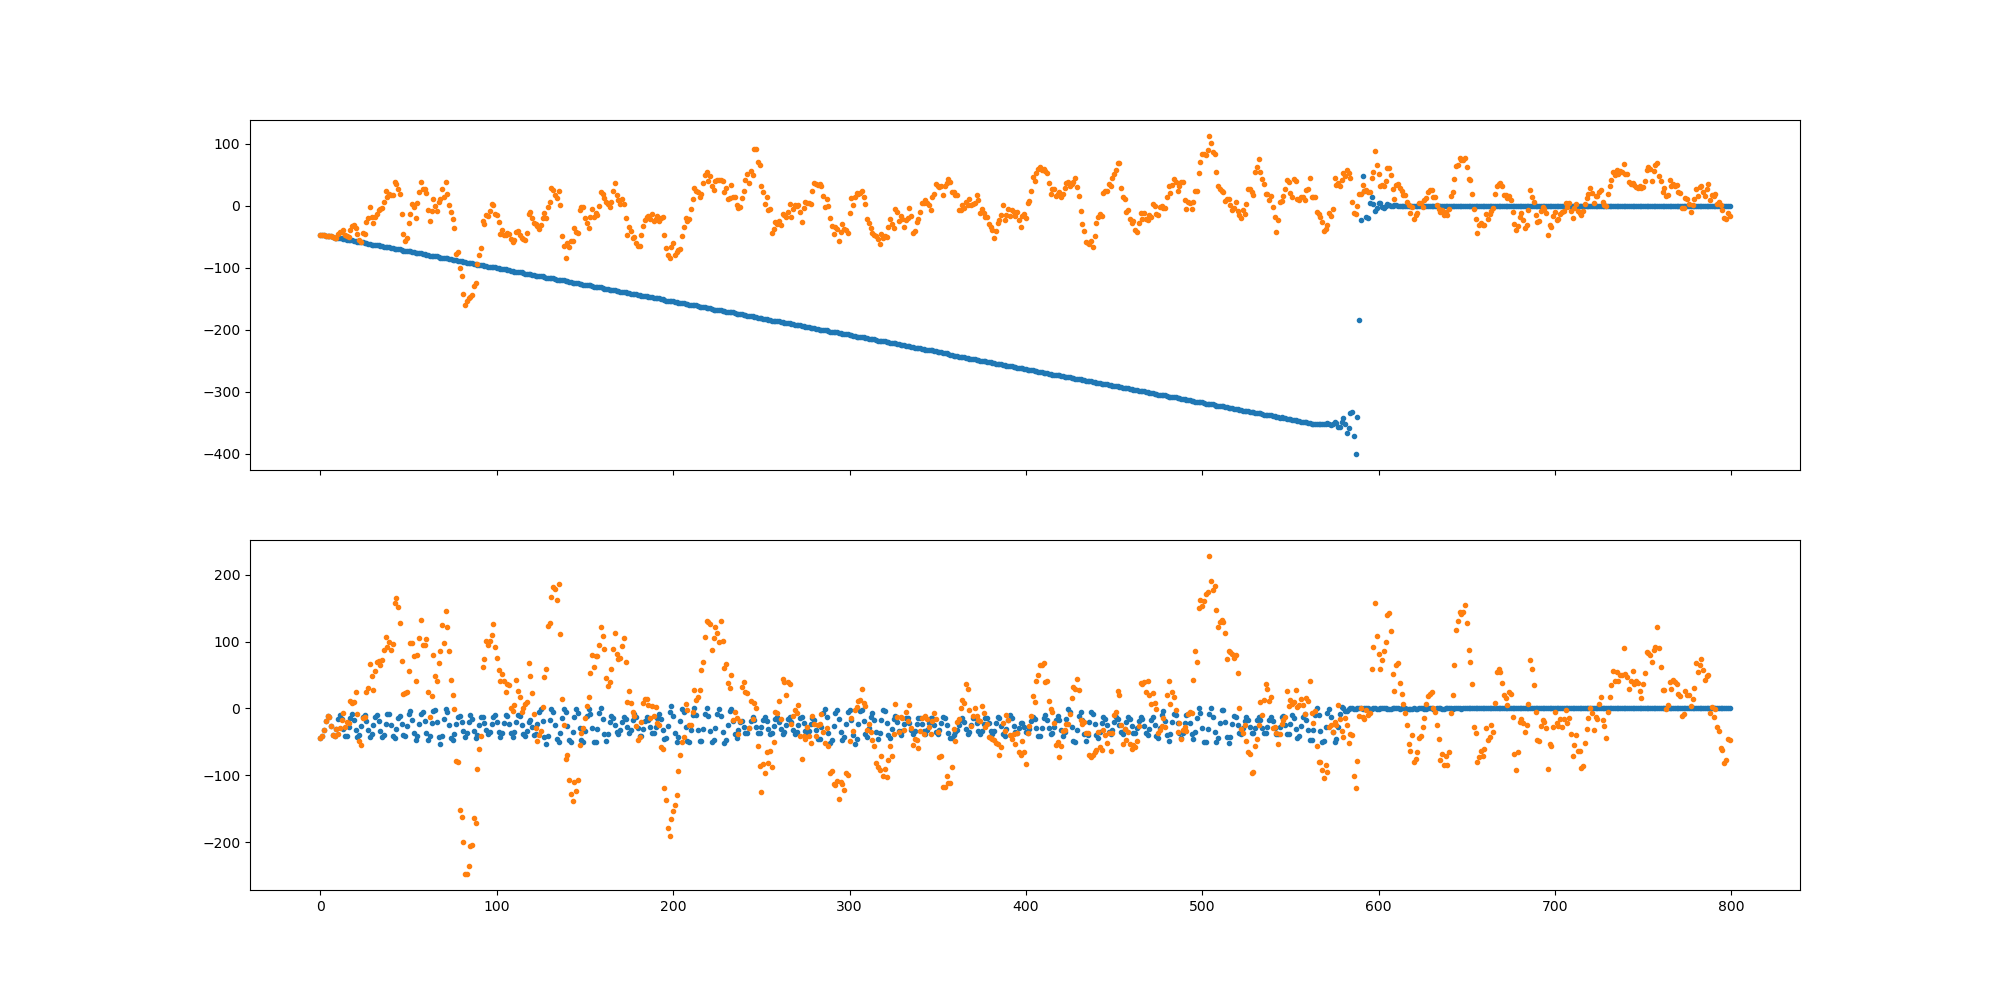

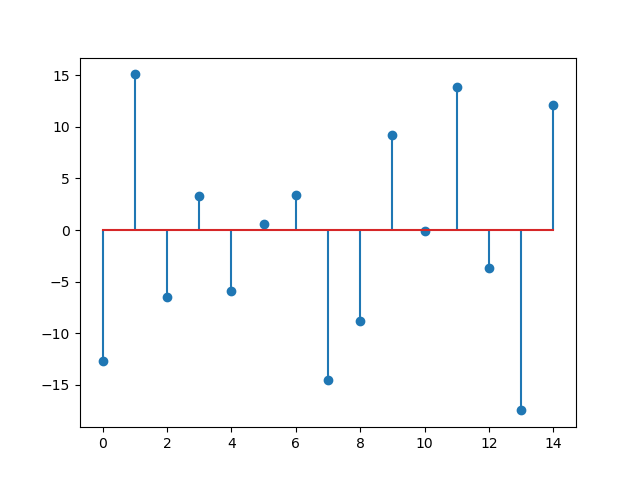

In [23]:
%matplotlib ipympl

from sklearn.linear_model import LinearRegression
SMOOTH_KERNEL = 10
x = features.values.copy().astype(float)
# x = clusters.values.T.copy().astype(float)

for i in range(x.shape[0]):
    x[i] = np.convolve(x[i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
x = x-x.mean(axis=1, keepdims=True)
x /= x.std(axis=1, keepdims=True)
xsk = x.T

y = np.vstack((signal.resample_poly(u, x.shape[1], len(u), padtype='line'), signal.resample_poly(du_dt, x.shape[1], len(du_dt), padtype='line')))
ysk = y.T

fit_slice = slice(1000, -1000)
model = LinearRegression(fit_intercept=False)
model.fit(xsk[fit_slice], ysk[fit_slice])
y_hat = model.predict(xsk)
print(model.score(xsk[fit_slice], ysk[fit_slice]))

fig, ax = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
ax[0].plot(y[0], ".")
ax[0].plot(y_hat[:, 0], ".")
ax[1].plot(y[1], ".")
ax[1].plot(y_hat[:, 1], ".")

fig, ax = plt.subplots()
ax.stem(model.coef_[0])


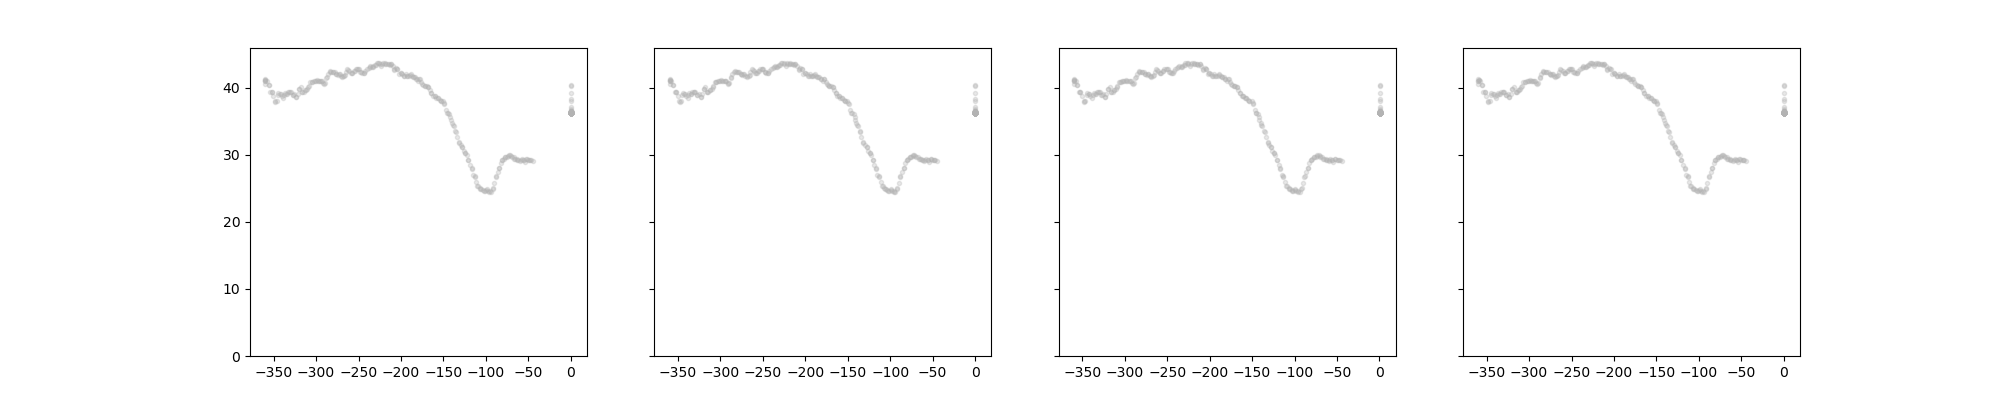

In [ ]:
# %matplotlib inline
fig, ax = plt.subplots(ncols=len(clusters.cluster), figsize=(20, 4), sharex=True, sharey=True)
bins = np.linspace(0, 1, 40)
for cluster in clusters.cluster:
    x = clusters.isel(cluster=cluster).values.copy()
    y = Param.norm_cy.values.copy()
    y = signal.resample_poly(y, len(x), len(y), padtype='line')
    ax[cluster.values].plot(Param.norm_cy,Param.PARA1*1e-3,'.',alpha=0.3,c="0.7")
    ax[cluster.values].hist(y[x], bins, alpha=0.4, density=True)
